# Reading In Data

In [9]:
%matplotlib inline

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

#Read in data
Feb_hrl_lmps = pd.read_csv('Feb_hrl_lmps.csv')
Feb_auction = pd.read_csv('Feb_auction.csv')

#Convert column to datetimes
Feb_hrl_lmps['datetime_beginning_ept'] = pd.to_datetime(Feb_hrl_lmps['datetime_beginning_ept'])

#Convert to matrix format
Feb_hrl_lmps = Feb_hrl_lmps.pivot(index = 'datetime_beginning_ept', columns = 'pnode_id', values = 'congestion_price_da')

In [11]:
Feb_hrl_lmps.sample(3)

pnode_id,1,3,48592,48593,48594,48595,48596,48603,48604,48605,...,2156112519,2156112520,2156112521,2156112523,2156112524,2156112525,2156112528,2156112529,2156112530,2156112531
datetime_beginning_ept,,,,,,,,,,,,,,,,,,,,,
2022-02-02 13:00:00,2.068814,-0.521079,-0.30,-0.30,36.47,36.47,36.47,30.56,30.56,-2.72,...,-2.52,-0.11,-2.24,0.37,-1.37,4.87,-0.95,1.96,-2.71,-5.04
2022-02-17 07:00:00,0.844502,2.239511,-8.52,-8.52,-4.05,-4.05,-4.05,-4.83,-4.83,-9.47,...,-6.11,0.87,-4.83,-8.35,-1.28,5.67,-1.31,4.76,-12.76,-8.36
2022-02-27 13:00:00,0.219563,0.147371,-3.27,-3.27,-3.16,-3.16,-3.16,-3.19,-3.19,-3.55,...,0.70,0.84,0.86,-3.26,0.81,0.72,-0.90,0.77,-4.95,-3.64


In [12]:
Feb_auction.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Purchase Month
102280,259322019,OnPeak,BNCRFT,BCADDISN138 KV T1,32410573,MERCERBU138 KV T1,32411955,Buy,4.0,-53.31,2022-02-01
96351,258220891,OnPeak,AMAZAN,521 BRIS138 KV TR72,67719547,146 SAND34.5 KV L10643,32407113,Buy,1.8,-38.69,2022-02-01
73098,257383292,OffPeak,APOETR,DOREMUSP138 KV DOREMUSP,106856861,MCCARTER26 KV UMD,2156111609,Sell,8.9,-237.69,2022-01-01


## Getting Total Congestion LMP for relevant hours

In [13]:
import numpy as np

def lookup_lmp(df, lmps):
    
    class_type = df.index[0]
    
    if class_type == 'OnPeak':
        f = ((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    elif class_type == 'OffPeak':
        f = ~((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    else:
        f = lmps.index.weekday <= 7 #All days of week
        
    avg_lmp = lmps[f].sum().rename('congestion_price_da')
    
    df = df.merge(avg_lmp, left_on = 'Source PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Source clmp'})
    
    df = df.merge(avg_lmp, left_on = 'Sink PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Sink clmp'})
    
    return df

auc_results = Feb_auction.groupby('Class Type').apply(lookup_lmp, Feb_hrl_lmps)
auc_results.reset_index(drop=True, inplace = True)

In [14]:
auc_results.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Purchase Month,Source clmp,Sink clmp
13385,257445227,OffPeak,DCEMA,COOK,34509185,DEERCREE34 KV DEERCRSP,1318144619,Sell,3.1,3470.49,2022-01-01,-1879.800000,912.09
97395,259456158,OnPeak,BLKOC,JACK PS 69 KV JACKPSSP,2156109166,HINCHMAN13 KV HINCHMSP,2156109427,Buy,5.0,59.77,2022-02-01,3025.930000,3344.29
3035,257864878,OffPeak,JANESE,BUCK-CIN,35079889,D_C_GEN 13 KV CT1,119118255,Buy,1.5,-121.58,2022-01-01,800.982257,753.92


# Analyzing the Premia for Each FTR

In [15]:
#Compute the Premium for each FTR
auc_results['Payoff'] = auc_results['Sink clmp'] - auc_results['Source clmp']
auc_results['Premium'] = auc_results['Payoff'] - auc_results['Obligation MCP']

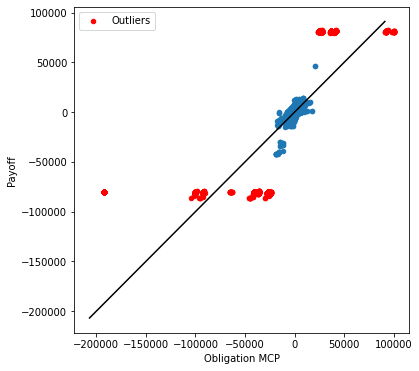

In [16]:
def plot_xy(ax, color='black'):
    l = min(ax.get_xlim()[0], ax.get_ylim()[0])
    r = min(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([l, r], [l, r], color = color)
    
    
fig, ax = plt.subplots(1,1, figsize=(6,6))

buy_trades = auc_results['Trade Type'] == 'Buy'
outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers].plot.scatter('Obligation MCP', 'Payoff',ax=ax)

auc_results[outliers].plot.scatter('Obligation MCP', 'Payoff',ax=ax, label='Outliers',color='red')
c=50000
plot_xy(ax)

In [17]:
auc_results[~outliers].shape[0]

161362

Text(0.5, 1.0, 'Sell Trades, No Outliers: Mean -168.05, Std 5211.12')

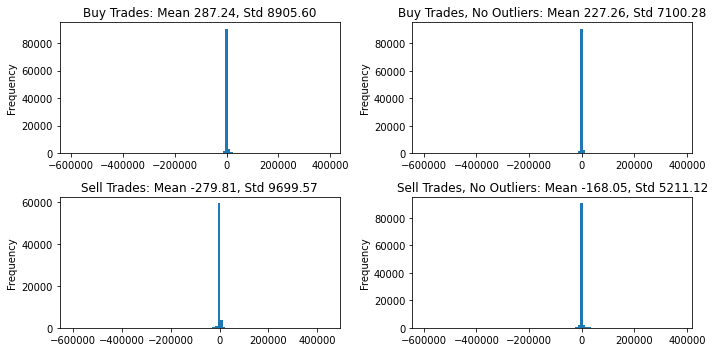

In [18]:
import numpy as np

def bool_to_pm1(xbool_):
    xpm1 = np.ones(xbool_.shape[0])
    xpm1[~xbool_] = -1
    return xpm1

auc_results['Premium'] = auc_results['Cleared MW']*(auc_results['Payoff'] - auc_results['Obligation MCP'])*bool_to_pm1(buy_trades)

fig, ax = plt.subplots(2,2, figsize = (10,5), tight_layout = True)

auc_results[buy_trades]['Premium'].plot.hist(bins = 100, ax = ax[0,0])
ax[0,0].set_title('Buy Trades: Mean {:.2f}, Std {:.2f}'.format(auc_results[buy_trades]['Premium'].mean(), auc_results[buy_trades]['Premium'].std()))

auc_results[buy_trades & ~outliers]['Premium'].plot.hist(bins = 100, ax = ax[0,1])
ax[0,1].set_title('Buy Trades, No Outliers: Mean {:.2f}, Std {:.2f}'.format(auc_results[buy_trades & ~outliers]['Premium'].mean(), auc_results[buy_trades & ~outliers]['Premium'].std()))

auc_results[~buy_trades]['Premium'].plot.hist(bins = 100, ax = ax[1,0])
ax[1,0].set_title('Sell Trades: Mean {:.2f}, Std {:.2f}'.format(auc_results[~buy_trades]['Premium'].mean(), auc_results[~buy_trades]['Premium'].std()))

auc_results[buy_trades & ~outliers]['Premium'].plot.hist(bins = 100, ax = ax[1,1])
ax[1,1].set_title('Sell Trades, No Outliers: Mean {:.2f}, Std {:.2f}'.format(auc_results[~buy_trades & ~outliers]['Premium'].mean(), auc_results[~buy_trades & ~outliers]['Premium'].std()))

In [19]:
#Making sure it's sorted by date
Feb_hrl_lmps.sort_index(inplace=True)

## Exploring how volatility affects premia

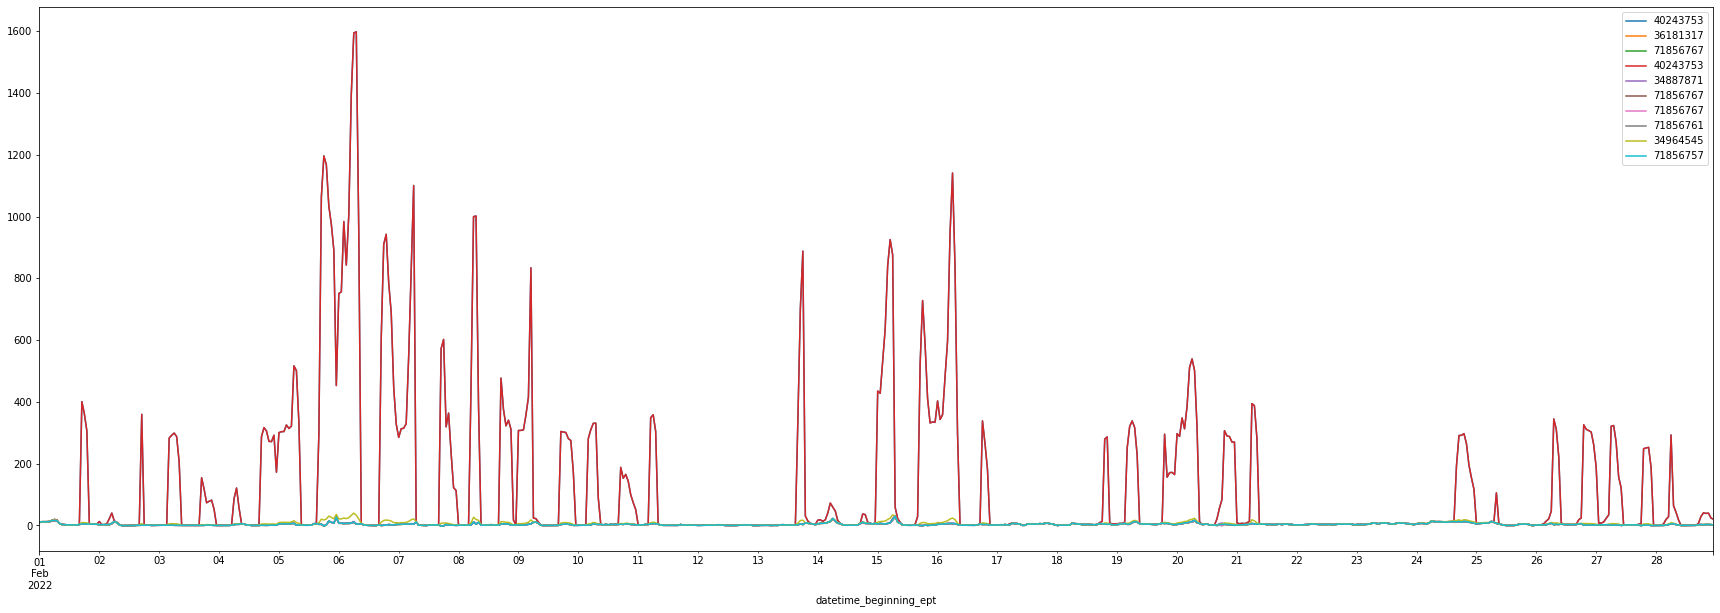

In [20]:
fig, ax = plt.subplots(1,1,figsize=(30,10))

for s in auc_results[outliers]['Sink PNODEID'].sample(10):
    Feb_hrl_lmps.plot(y = s, ax=ax, label = str(s))
    
ax.legend()

## Computing Vols

<AxesSubplot:>

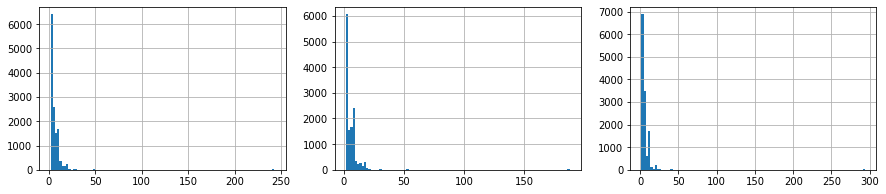

In [21]:
onpeak = ((Feb_hrl_lmps.index.weekday <= 5) &\
     (Feb_hrl_lmps.index.hour >= 7) &\
     (Feb_hrl_lmps.index.hour < 23))
offpeak = ~onpeak

fig, ax = plt.subplots(1, 3, figsize = (15,3))
Feb_hrl_lmps.std().hist(bins = 100, ax = ax[0])
Feb_hrl_lmps[onpeak].std().hist(bins = 100, ax = ax[1])
Feb_hrl_lmps[offpeak].std().hist(bins=100, ax = ax[2])

<AxesSubplot:xlabel='datetime_beginning_ept'>

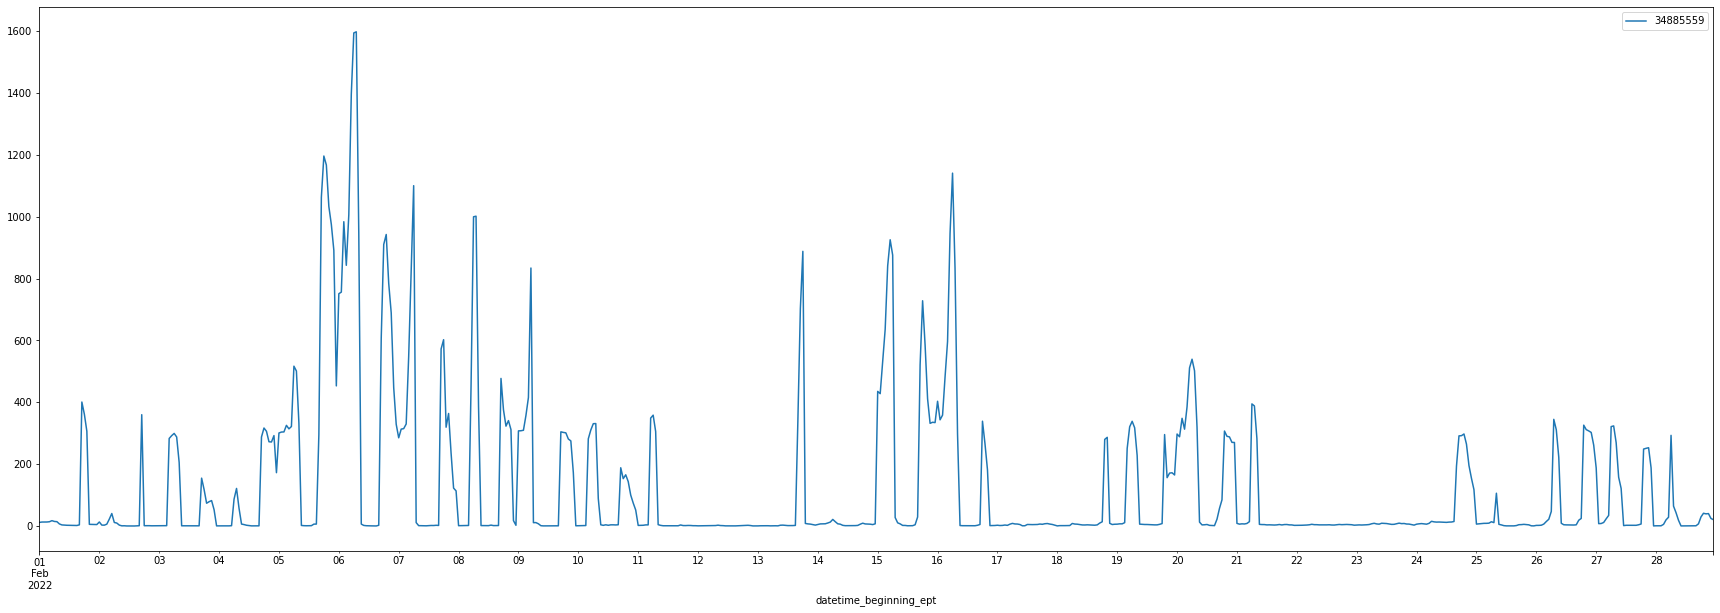

In [22]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
node_id = Feb_hrl_lmps.std().idxmax()
Feb_hrl_lmps.plot(y = node_id, ax = ax)

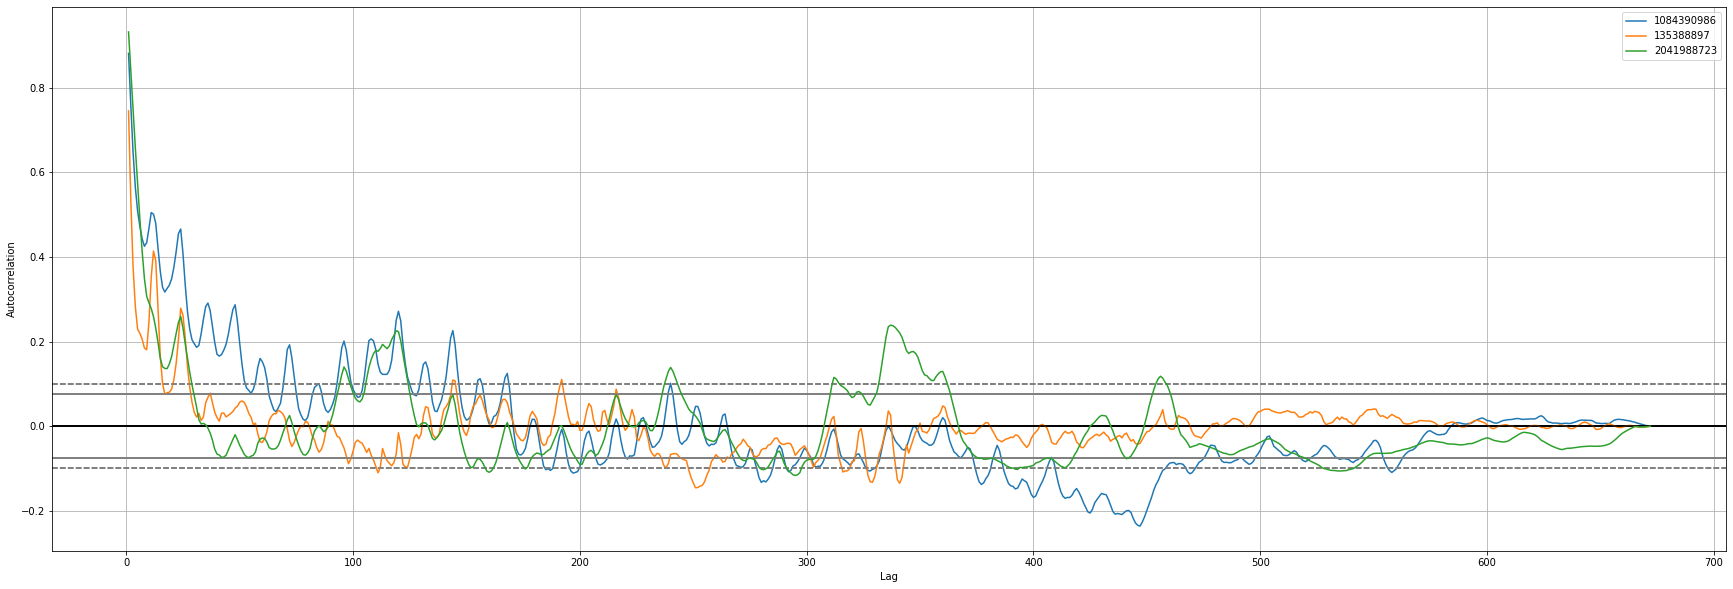

In [23]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(1,1,figsize=(30,10))

for s in auc_results[~outliers]['Source PNODEID'].sample(3):
    autocorrelation_plot(Feb_hrl_lmps[s], ax=ax, label = str(s))
    
ax.legend()

In [24]:
def lookup_vol(df, lmps):    
    source = df['Source PNODEID'].iloc[0]
    sink = df['Sink PNODEID'].iloc[0]
    #return lmps[source].cov(lmps[sink])
    return (lmps[source]-lmps[sink]).std()
    
class_types = ['OffPeak', 'OnPeak', '24H']
split_auc = {}
lmp_filt = {}

for c in class_types:
    split_auc[c] = auc_results[auc_results['Class Type'] == c]
    if c == 'OnPeak':
        lmp_filt[c] = ((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    elif c == 'OffPeak':
        lmp_filt[c] = ~((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    else:
        lmp_filt[c] = Feb_hrl_lmps.index.weekday <= 7 #All days of week
        

for c in class_types:
    new = split_auc[c].groupby(by=['Source PNODEID', 'Sink PNODEID']).apply(lookup_vol, Feb_hrl_lmps[lmp_filt[c]])
    new.rename('new', inplace=True)
    split_auc[c] = split_auc[c].merge(right=new, left_on = ['Source PNODEID', 'Sink PNODEID'], right_index = True)
    split_auc[c].rename(columns={'new':'FTR Vol'}, inplace=True)
    del new
    
auc_results = pd.concat([split_auc[c] for c in class_types], ignore_index=True)

<AxesSubplot:xlabel='FTR Vol', ylabel='Premium'>

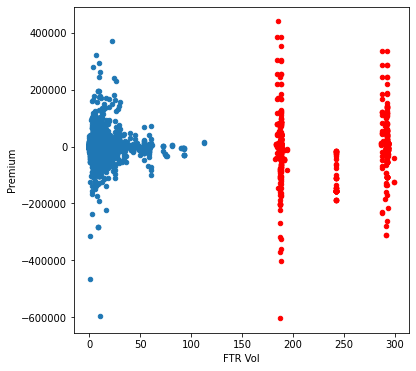

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

auc_results['FTR Percent Vol'] = auc_results['FTR Vol']/np.maximum(auc_results['Obligation MCP'].abs(),np.ones(auc_results.shape[0]))
outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers].plot.scatter(x='FTR Vol', y = 'Premium',ax=ax)
auc_results[outliers].plot.scatter(x='FTR Vol', y = 'Premium',ax=ax,color='red')

## Breaking down premium by month Purchased

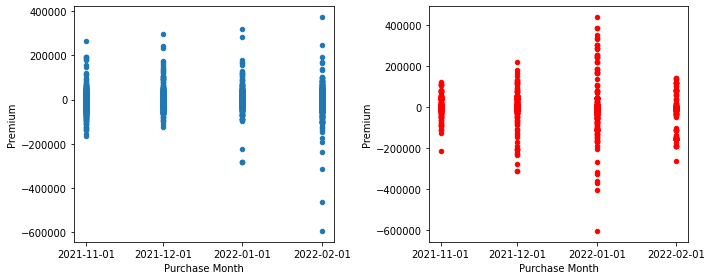

In [26]:
auc_results['Purchase Month'] = pd.to_datetime(auc_results['Purchase Month'])

fig, ax = plt.subplots(1,2,figsize=(10,4))


outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers].plot.scatter(y = 'Premium', x = 'Purchase Month', ax = ax[0])
auc_results[outliers].plot.scatter(y = 'Premium', x = 'Purchase Month', ax = ax[1], color='red')

for i in [0,1]:
    ax[i].set_xticks([ax[i].get_xticks()[j] for j in [0,2,4,6]])
    
fig.tight_layout()

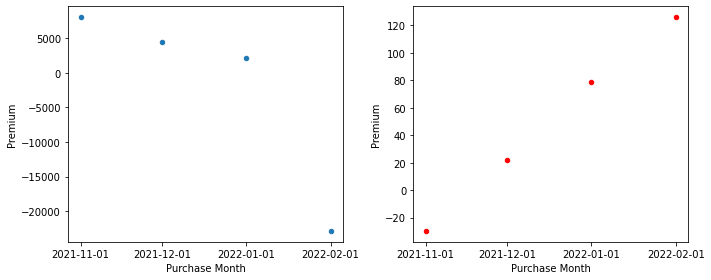

In [27]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

noout_mean = pd.DataFrame(auc_results[outliers].groupby('Purchase Month').apply(lambda x : x['Premium'].mean()).rename('Premium')).reset_index()
noout_mean.plot.scatter(x='Purchase Month',y='Premium',ax=ax[0])

out_mean = pd.DataFrame(auc_results[~outliers].groupby('Purchase Month').apply(lambda x : x['Premium'].mean()).rename('Premium')).reset_index()
out_mean.plot.scatter(x='Purchase Month',y='Premium',color='red',ax=ax[1])

for i in [0,1]:
    ax[i].set_xticks([ax[i].get_xticks()[j] for j in [0,2,4,6]])
    
fig.tight_layout()

# Look for Arbitrage (Price Disagreements)

In [173]:
#Makes a dictionary representation of a directed graph of edges
def make_graph(edges):
    g = {}
    for e in edges:
        if e[0] in g.keys():
            g[e[0]]['down'].append(e[1])
        else:
            g[e[0]] = {}
            g[e[0]]['down'] = [e[1]]
            g[e[0]]['up'] = []
            
        if e[1] in g.keys():
            g[e[1]]['up'].append(e[0])
        else:
            g[e[1]] = {}
            g[e[1]]['up'] = [e[0]]
            g[e[1]]['down'] = []
    
    return g

#Computes degree of a node in a directed graph
def get_degree(node):
    return len(node['up'])+len(node['down'])

degree = np.array([get_degree(g[node]) for node in g.keys()])

#Enumerates all triangles in a directed graph
def enum_tri(graph):
    
    triangles = []
    
    for node in graph.keys():
        
        up_nbrs = graph[node]['up']
        down_nbrs = graph[node]['down']
        checked_nbrs = set({node})
        
        #i -> node
        for i in up_nbrs:
            i_up = graph[i]['up']
            i_down = graph[i]['down']
            checked_nbrs.add(i)
            
            #j -> i
            for j in i_up: #need to prune j from i neighbors for the purposes of counting at this node
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[j,node],[j,i]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[node,j],[j,i]]))
                    
            #i -> j
            for j in i_down:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[j,node],[i,j]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[node,j],[i,j]])) 
                    
        #node -> i
        for i in down_nbrs:
            i_up = graph[i]['up']
            i_down = graph[i]['down']
            
            #j -> i
            for j in i_up:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[j,node],[j,i]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[node,j],[j,i]]))
                    
            #i -> j
            for j in i_down:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[j,node],[i,j]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[node,j],[i,j]]))
                    
        #Prune node from g
        graph[node]['up'] = []
        graph[node]['down'] = []
        for i in up_nbrs:
            try:
                graph[i]['down'].remove(node)
            except ValueError:
                print((i,node))
        for j in down_nbrs:
            graph[j]['up'].remove(node)
        
    return triangles

In [207]:
def count_tri(df):
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates()
    g = make_graph(edges.values)
    return len(enum_tri(g))

def sign(edge, ordered_nodes):
    if np.all(edge == [ordered_nodes[0],ordered_nodes[2]]):
        return -1
    elif np.all(edge == [ordered_nodes[2],ordered_nodes[0]]):
        return 1
    else:
        return np.sign(edge[1]-edge[0])

def arb(prices, triangle):
    arb_sum = 0
    for edge in triangle:
        premium = prices[(edge[0],edge[1])]
        arb_sum += premium*sign(edge, np.unique(triangle))
        
    #If you want to restrict to buy-only
    #return max(arb_sum,0)

    #If you dont restrict to buy-only
    #May double count edges
    return abs(arb_sum)
        
def total_arb(df):
    series = df.groupby(['Source PNODEID','Sink PNODEID']).apply(lambda x : x['Premium'].max())
    prices_dict = series.to_dict()
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates().values
    triangles = enum_tri(make_graph(edges))
    return sum([arb(prices_dict, t) for t in triangles])

In [210]:
f = auc_results['Source PNODEID'] == auc_results['Sink PNODEID']
arb = auc_results[~f & ~outliers].groupby('Purchase Month').apply(lambda x: total_arb(x))

In [211]:
def market_size(df):
    return (df['Obligation MCP']*df['Cleared MW']).abs().sum()*24*7*4

mrkt_size = auc_results[~outliers].groupby('Purchase Month').apply(market_size)

In [212]:
arb/mrkt_size

Purchase Month
2021-11-01    0.004267
2021-12-01    0.003421
2022-01-01    0.002775
2022-02-01    0.002879
dtype: float64